In [ ]:
import sys
import os
notebook_path = os.getcwd()
parent_path = os.path.abspath(os.path.join(notebook_path, ".."))
sys.path.append(parent_path)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import importlib

import modules.dataset_func as dataset_func
import modules.tools
importlib.reload(dataset_func)
importlib.reload(modules.tools)

from modules.dataset_func import remap_u_from_sim_grid
from modules.dataset_func import get_X_from_sim_grid
from modules.tools import heatmaps_from_one_sample
from modules.tools import get_feature_ranges
from modules.tools import get_scores_by_feature


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  

True
NVIDIA GeForce RTX 2060


In [ ]:
#import data

sim_grid_path = r"C:\Users\Antoine\Documents\master\PA\abacus\sim_plaque\ANNs\data\raw\20250331140859"

X, material_list = get_X_from_sim_grid(sim_grid_path, ["distances", "plaque_epaisseurs","materiaux"])
y, invalid_results = remap_u_from_sim_grid(sim_grid_path)
X = np.delete(X, invalid_results, axis=0)

print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

0/1680 done
1/1680 done
2/1680 done
3/1680 done
4/1680 done
5/1680 done
6/1680 done
7/1680 done
8/1680 done
9/1680 done
10/1680 done
11/1680 done
12/1680 done
13/1680 done
14/1680 done
15/1680 done
16/1680 done
17/1680 done
18/1680 done
19/1680 done
20/1680 done
21/1680 done
22/1680 done
23/1680 done
24/1680 done
25/1680 done
26/1680 done
27/1680 done
28/1680 done
29/1680 done
30/1680 done
31/1680 done
32/1680 done
33/1680 done
34/1680 done
35/1680 done
36/1680 done
37/1680 done
38/1680 done
39/1680 done
40/1680 done
41/1680 done
42/1680 done
43/1680 done
44/1680 done
45/1680 done
46/1680 done
47/1680 done
48/1680 done
49/1680 done
50/1680 done
51/1680 done
52/1680 done
53/1680 done
54/1680 done
55/1680 done
56/1680 done
57/1680 done
58/1680 done
59/1680 done
60/1680 done
61/1680 done
62/1680 done
63/1680 done
64/1680 done
65/1680 done
66/1680 done
67/1680 done
68/1680 done
69/1680 done
70/1680 done
71/1680 done
72/1680 done
73/1680 done
74/1680 done
75/1680 done
76/1680 done
77/1680 d

In [4]:
print(len(material_list))

1680


In [5]:
def get_min_max_from_feature(feature_ind, X):
    min = np.min(X[:,feature_ind])
    max = np.max(X[:,feature_ind])

    print(f"min feature {feature_ind} : {min}")
    print(f"max feature {feature_ind} : {max}")


for i in range(X.shape[1]):
    get_min_max_from_feature(i, X)


min feature 0 : 5.0
max feature 0 : 190.0
min feature 1 : 0.5
max feature 1 : 20.0
min feature 2 : 69000.0
max feature 2 : 210000.0
min feature 3 : 2.7e-09
max feature 3 : 8.96e-09
min feature 4 : 0.26
max feature 4 : 0.36


In [6]:
#reduce the input range
X_reduced, y_reduced = X,y
print(X_reduced.shape)
print(y_reduced.shape)

(1373, 5)
(1373, 24, 24)


In [7]:
#add canal dim y for the inv CNN
y_expanded = np.expand_dims(y_reduced, axis=1)
print(y_expanded.shape)

(1373, 1, 24, 24)


In [8]:
#normalisation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_reduced)


"""
scaler_y = StandardScaler()
y_shape = y.shape
y_transformed = y.reshape(y.shape[0],-1)
y_scaled = scaler_y.fit_transform(y_transformed)
y_scaled = y_scaled.reshape(y_shape)
"""
y_scaled = np.abs(y_expanded)


print(f"X_scaled shape : {X_scaled.shape}")
print(f"y_scaled shape : {y_scaled.shape}")

print(X_scaled)

X_scaled shape : (1373, 5)
y_scaled shape : (1373, 1, 24, 24)
[[0.         0.         1.         0.82428115 0.        ]
 [0.         0.         0.39007092 1.         1.        ]
 [0.         0.         0.         0.         0.7       ]
 ...
 [1.         1.         0.39007092 1.         1.        ]
 [1.         1.         0.         0.         0.7       ]
 [1.         1.         0.31914894 0.28753994 0.8       ]]


In [9]:
#to tenseur
X_tenseur = torch.from_numpy(X_scaled.astype(np.float32))
y_tenseur = torch.from_numpy(y_scaled.astype(np.float32))
X_size = X.shape[1]
y_size = y.shape[1]

print(X_tenseur.shape)
print(y_tenseur.shape)

torch.Size([1373, 5])
torch.Size([1373, 1, 24, 24])


In [10]:

# train 0.8, test 0.1, val 0.1
X_train, X_temp, y_train, y_temp = train_test_split(X_tenseur, y_tenseur, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print("device : ", device)

print(f"X_val is on {X_val.device}")
print(f"y_val is on {y_val.device}")

print(f"X_test is on {X_test.device}")
print(f"y_test is on {y_test.device}")

print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print("\n")
print(f"X_val shape : {X_val.shape}")
print(f"y_val shape : {y_val.shape}")
print("\n")
print(f"X_test shape : {X_test.shape}")
print(f"y_test shape : {y_test.shape}")

device :  cuda
X_val is on cuda:0
y_val is on cuda:0
X_test is on cuda:0
y_test is on cuda:0
X_train shape : torch.Size([1098, 5])
y_train shape : torch.Size([1098, 1, 24, 24])


X_val shape : torch.Size([138, 5])
y_val shape : torch.Size([138, 1, 24, 24])


X_test shape : torch.Size([137, 5])
y_test shape : torch.Size([137, 1, 24, 24])


In [25]:
class INV_CNN_displacement(nn.Module):
    def __init__(self):
        super(INV_CNN_displacement, self).__init__()

        # MLP pour transformer l'entrée de taille 5 en taille 9
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 9),
            nn.ReLU()
        )

        # Décodeur convolutionnel
        self.decoder = nn.Sequential(
            # Entrée : (batch_size, 1, 3, 3)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),

        )

    def forward(self, x):
        x = self.mlp(x)                  # (batch, 9)
        x = x.view(-1, 1, 3, 3)          # (batch, 1, 3, 3)
        x = self.decoder(x)             # (batch, 1, 24, 24)
        return x

In [26]:
#test output shape
from torchsummary import summary
test_model = INV_CNN_displacement().cpu()
summary(test_model, input_size=(1,5), device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]             192
              ReLU-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 64]           2,112
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 32]           2,080
              ReLU-6                [-1, 1, 32]               0
            Linear-7                 [-1, 1, 9]             297
              ReLU-8                 [-1, 1, 9]               0
            Conv2d-9             [-1, 32, 3, 3]             320
             ReLU-10             [-1, 32, 3, 3]               0
         Upsample-11             [-1, 32, 6, 6]               0
           Conv2d-12             [-1, 64, 6, 6]          18,496
             ReLU-13             [-1, 64, 6, 6]               0
         Upsample-14           [-1, 64,

In [27]:
model_displacement = INV_CNN_displacement().to(device)

def train(model, device, X_train, y_train, X_val, y_val, batch_size=32, num_epochs= 1000, patience=20):


    print(next(model.parameters()).device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    from torch.utils.data import TensorDataset, DataLoader


    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


    epochs = []
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')  # Initialize with a very high value
    epochs_no_improve = 0  # Counter to track epochs without improvement
    best_model_weights = None  # To store the best model's weights

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        epoch_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward
            pred = model(batch_X)
            loss = criterion(pred, batch_y)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_X.size(0)  # accumulate total loss

        avg_train_loss = epoch_loss / len(train_loader.dataset)

        # Validation Phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():  # No need to compute gradients during validation
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)            

                pred = model(batch_X)
                loss = criterion(pred, batch_y)
                val_loss += loss.item() * batch_X.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)

        epochs.append(epoch+1)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict()  # Save the best model weights
            epochs_no_improve = 0  # Reset counter if improvement
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Restore the best model weights after training
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return epochs, train_losses, val_losses

epochs, train_losses, val_losses = train(model_displacement, device, X_train, y_train, X_val, y_val, patience=50)

cuda:0
Epoch 1/1000 - Train Loss: 357.5680 - Validation Loss: 243.8014
Epoch 2/1000 - Train Loss: 294.7980 - Validation Loss: 229.8309
Epoch 3/1000 - Train Loss: 267.8982 - Validation Loss: 199.2729
Epoch 4/1000 - Train Loss: 220.1249 - Validation Loss: 157.5826
Epoch 5/1000 - Train Loss: 177.8782 - Validation Loss: 125.9391
Epoch 6/1000 - Train Loss: 133.1611 - Validation Loss: 97.4901
Epoch 7/1000 - Train Loss: 110.0960 - Validation Loss: 78.3414
Epoch 8/1000 - Train Loss: 95.4601 - Validation Loss: 78.4471
Epoch 9/1000 - Train Loss: 87.3985 - Validation Loss: 73.3392
Epoch 10/1000 - Train Loss: 80.1993 - Validation Loss: 61.7428
Epoch 11/1000 - Train Loss: 74.7580 - Validation Loss: 58.4563
Epoch 12/1000 - Train Loss: 71.8322 - Validation Loss: 57.7654
Epoch 13/1000 - Train Loss: 67.3454 - Validation Loss: 52.2796
Epoch 14/1000 - Train Loss: 61.6648 - Validation Loss: 52.9195
Epoch 15/1000 - Train Loss: 58.9835 - Validation Loss: 48.2146
Epoch 16/1000 - Train Loss: 56.4803 - Validat

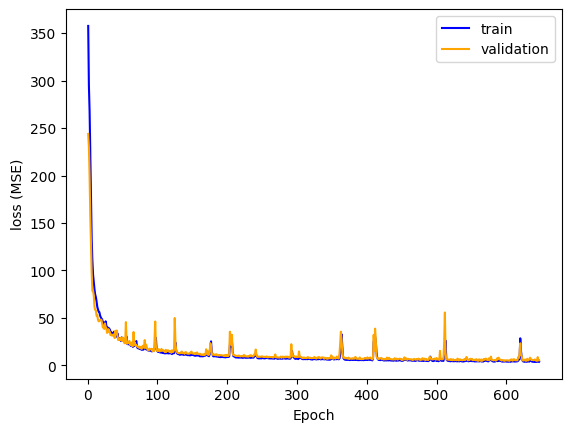

In [28]:
def plot_loss(epochs, train_losses, val_losses):
    plt.plot(epochs, train_losses, color="blue", label="train")
    plt.plot(epochs, val_losses, color="orange", label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("loss (MSE)")
    plt.legend()
    plt.show()

plot_loss(epochs, train_losses, val_losses)

In [29]:

def denorm_y(y_norm, scaler) :
    y_shape = y_norm.shape
    y_transformed = y_norm.reshape(y_norm.shape[0],-1)
    y_denorm = scaler.inverse_transform(y_transformed)
    y_denorm = y_denorm.reshape(y_shape)

    return y_denorm

def get_mse(model, X_test, y_test):
    # inference MSE score
    model.eval()

    with torch.no_grad():  
        y_pred = model(X_test)

    mse_loss = nn.MSELoss()
    mse = mse_loss(y_pred, y_test)

    return mse

mse = get_mse(model_displacement,X_test, y_test)

print(f"MSE: {mse.item():.4f}")



MSE: 3.7662


In [ ]:
print(X_test.shape)



X_test_demormed = scaler_X.inverse_transform(X_test.cpu())

dists = X_test_demormed[:,0]
epaiss = X_test_demormed[:,1]

dist_ranges = get_feature_ranges(dists, 10)
epais_ranges = get_feature_ranges(epaiss, 20)

torch.Size([137, 5])
137
137


In [ ]:
model_displacement.eval()

with torch.no_grad():  
    y_pred = model_displacement(X_test)


print(get_scores_by_feature(y_test, y_pred, material_list, "material"))
print("\n")
print(get_scores_by_feature(y_test, y_pred, dist_ranges, "distance"))
print("\n")
print(get_scores_by_feature(y_test, y_pred, epais_ranges, "epaisseur"))

    material       mse
0      acier  1.833894
1  aluminium  6.395932
2     cuivre  5.490986
3      titan  1.400804


   distance       mse
0      23.5  0.148620
1      42.0  0.302832
2      60.5  0.367934
3      79.0  0.624255
4      97.5  7.669897
5     116.0  1.462040
6     134.5  0.746678
7     153.0  7.208094
8     171.5  5.206656
9     190.0  7.708759


    epaisseur        mse
0       1.475  12.453184
1       2.450   2.992607
2       3.425   8.210225
3       4.400   6.737560
4       5.375   2.990637
5       6.350   1.098934
6       7.325   0.372071
7       8.300   0.534739
8       9.275   1.906351
9      10.250   1.034595
10     11.225   2.340200
11     12.200   1.352629
12     13.175   1.072949
13     14.150   1.826578
14     15.125   1.303237
15     16.100   0.276855
16     17.075   0.100721
17     18.050   7.125204
18     19.025   0.269156
19     20.000   2.630077


torch.Size([137, 1, 24, 24])
(20, 1, 24, 24)


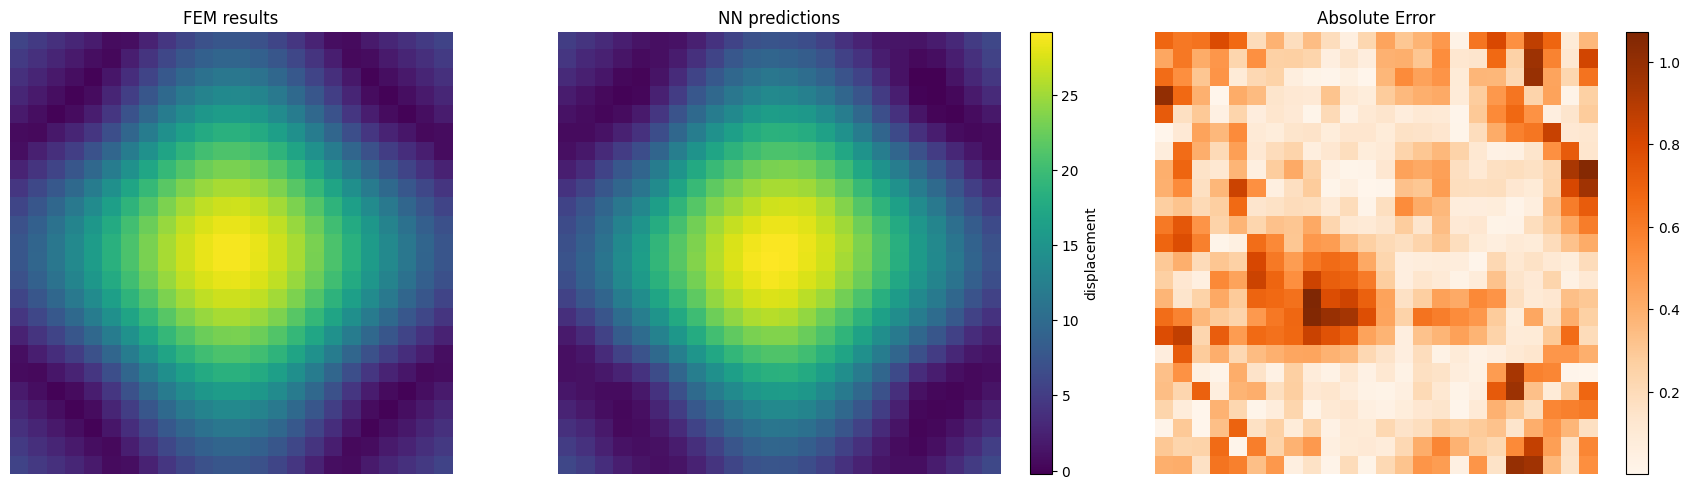

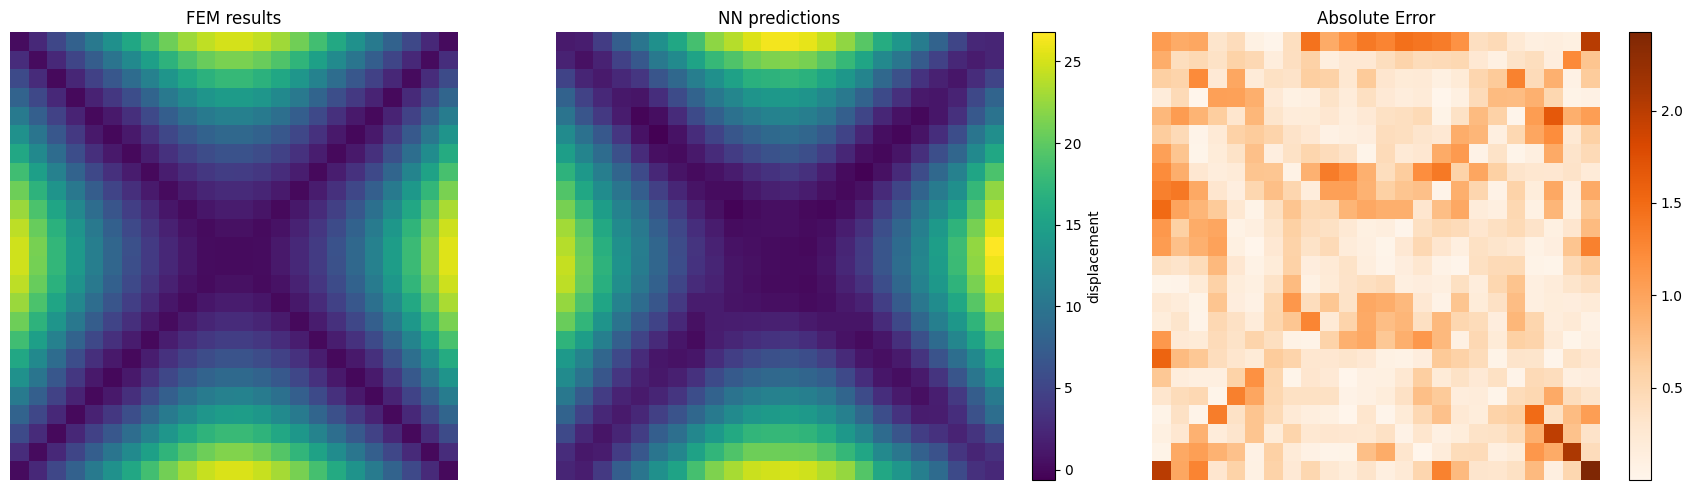

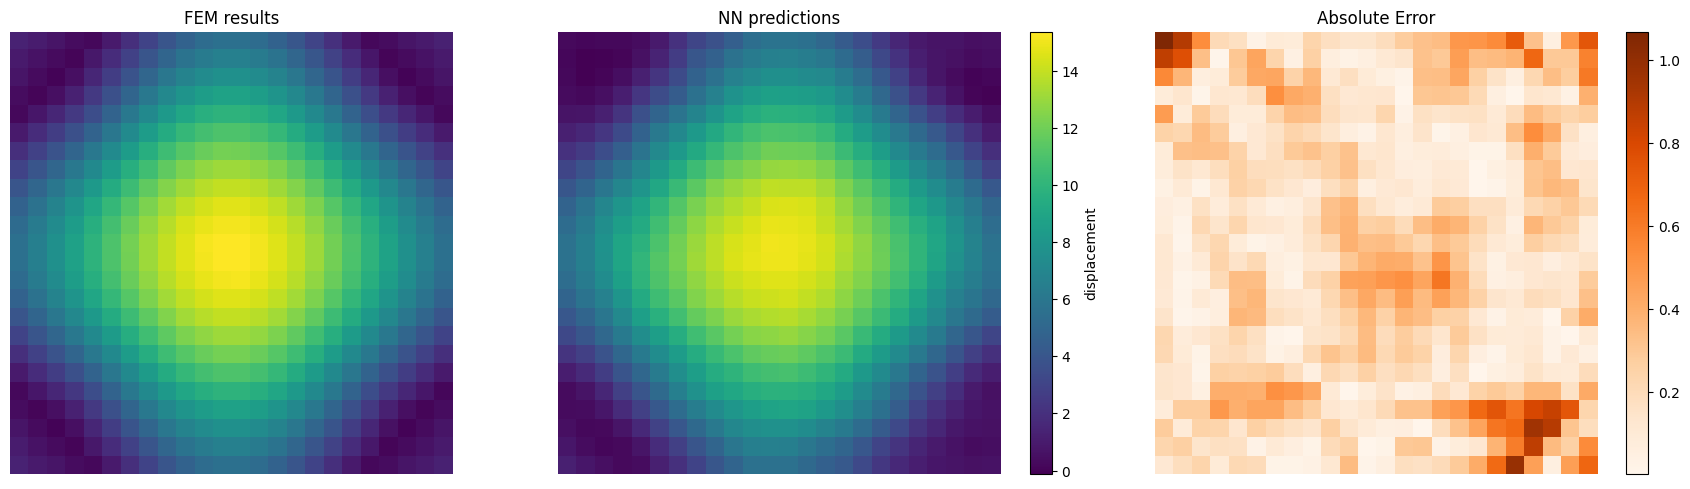

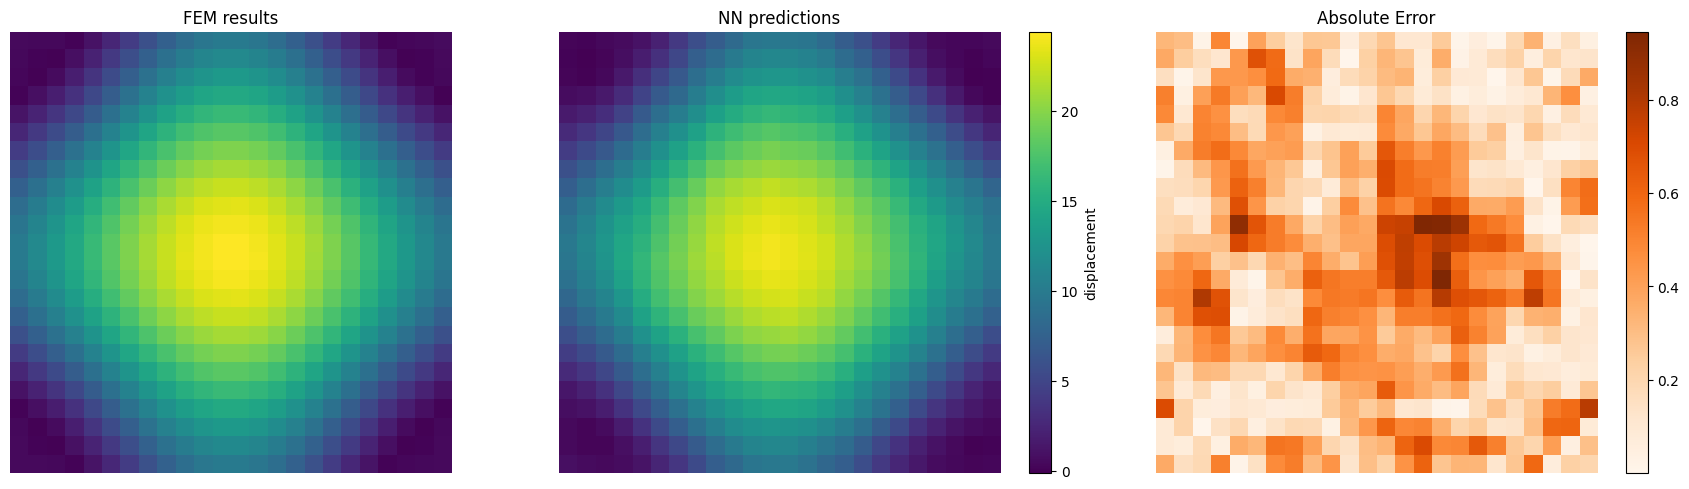

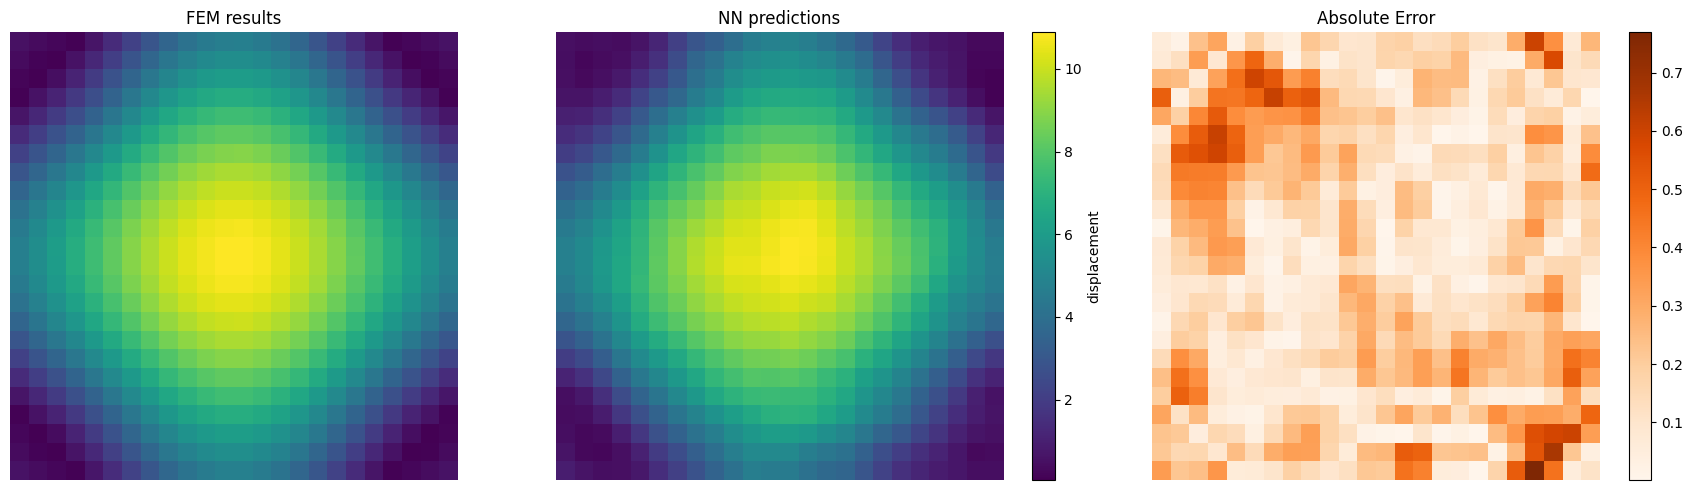

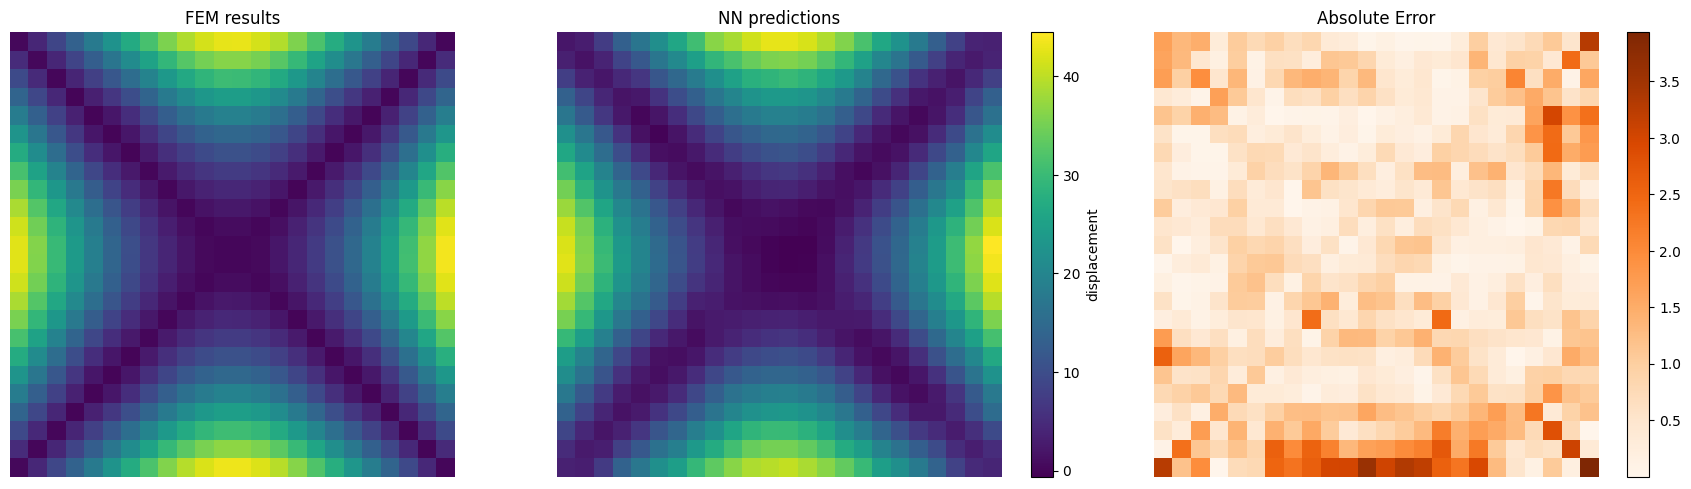

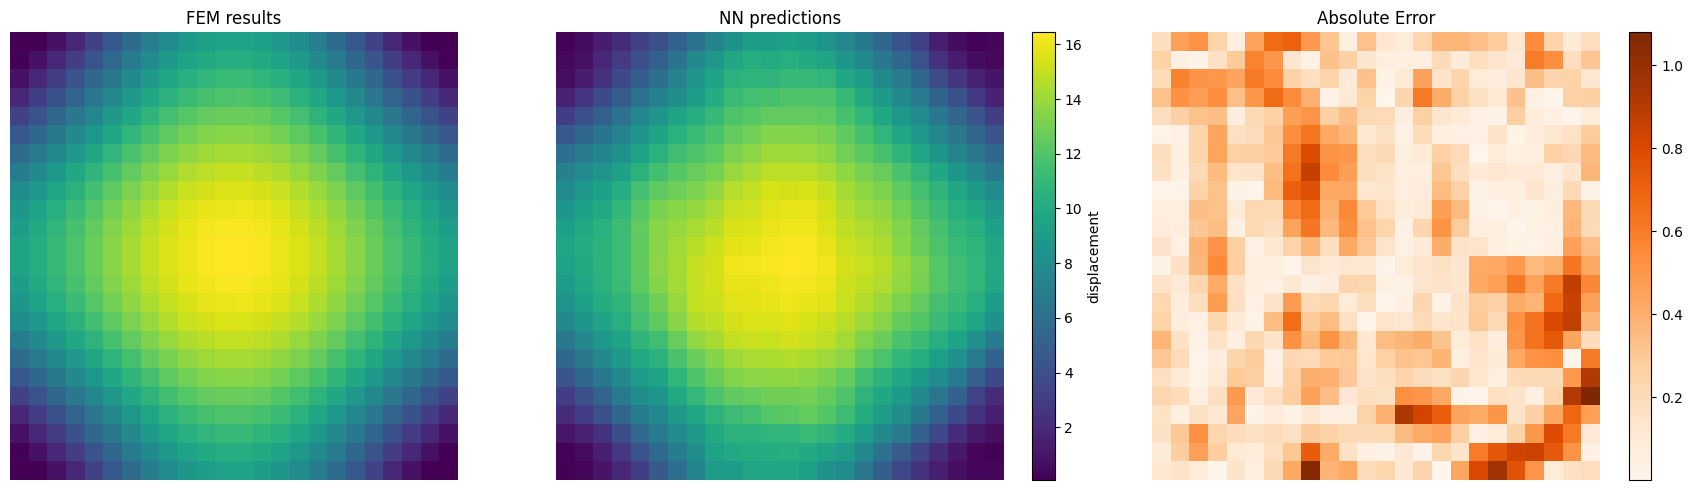

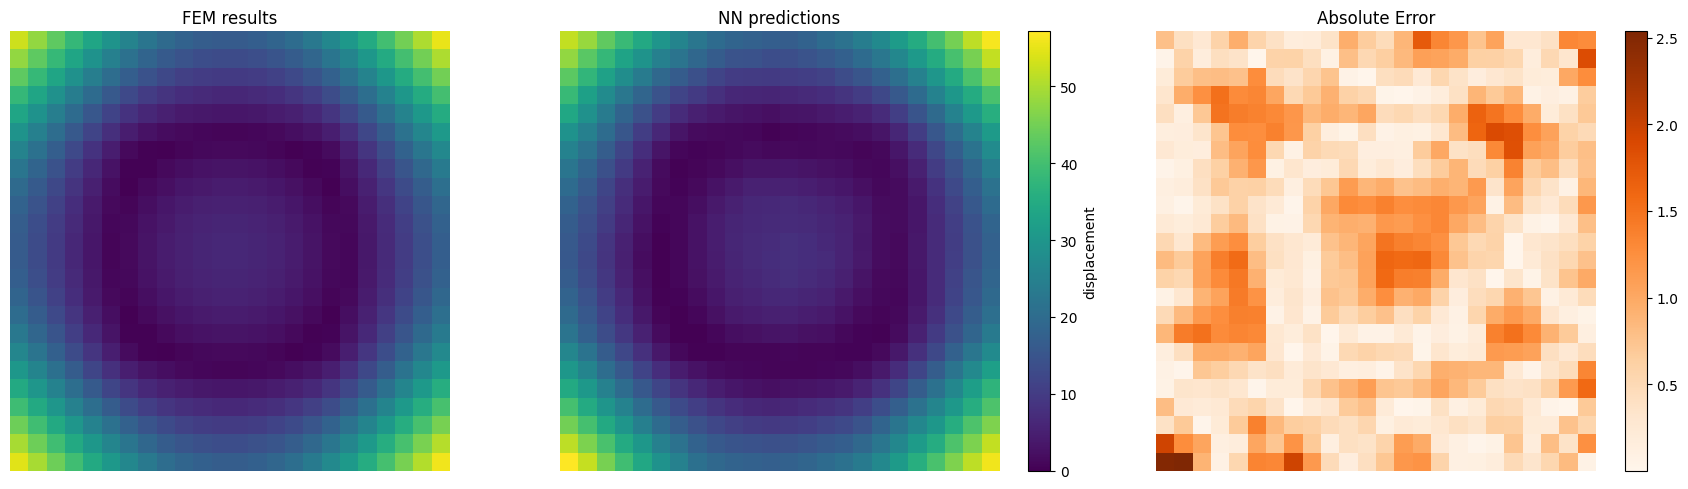

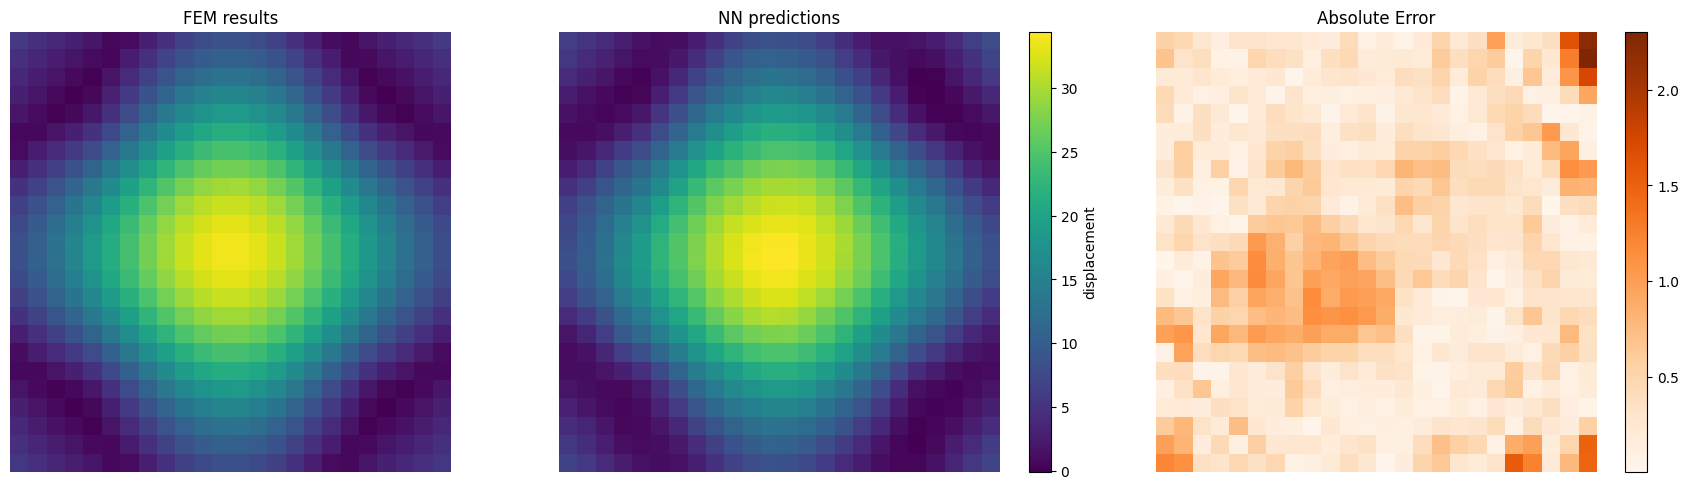

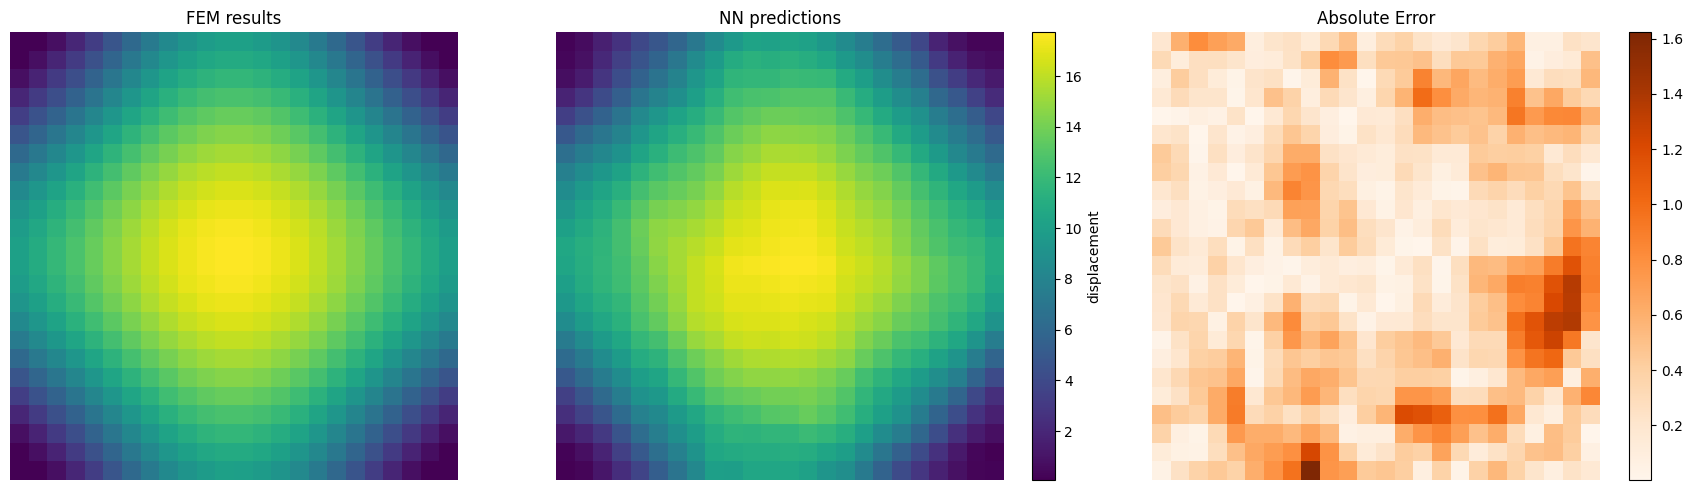

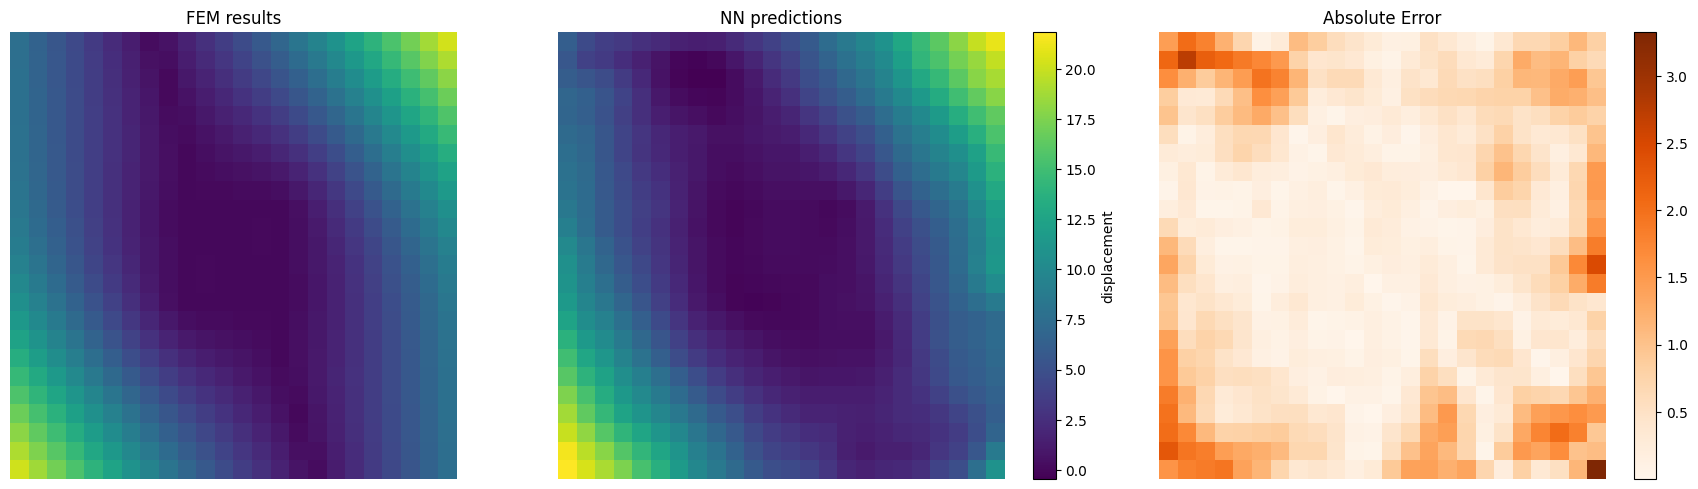

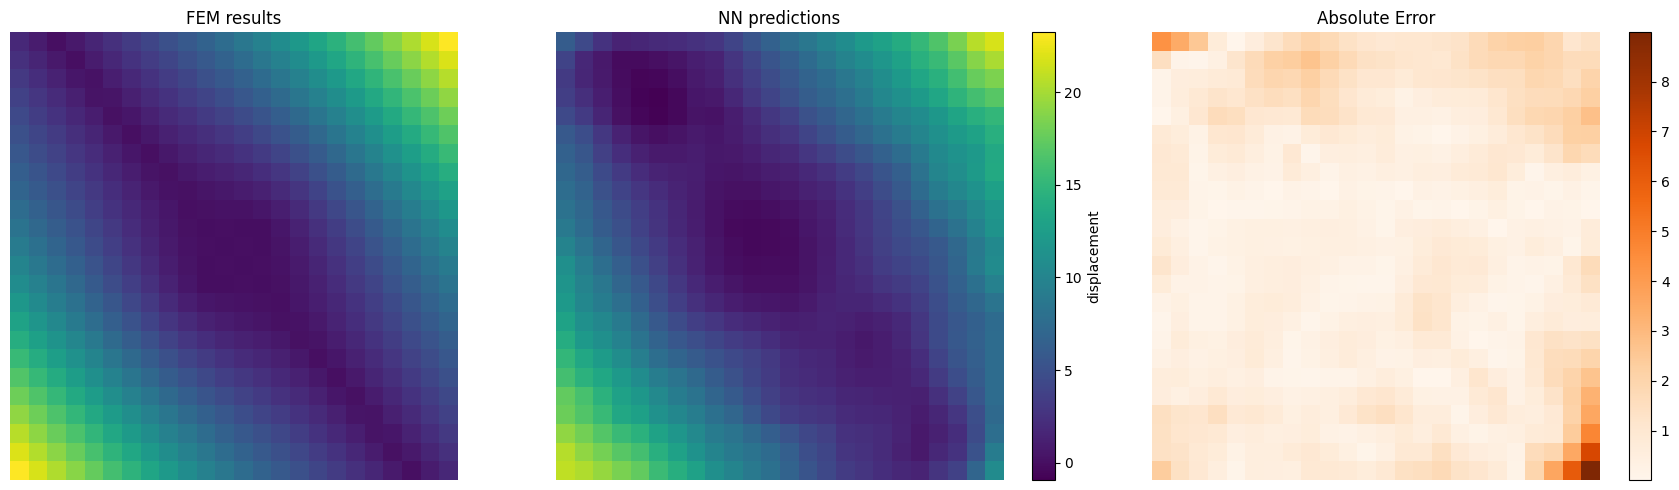

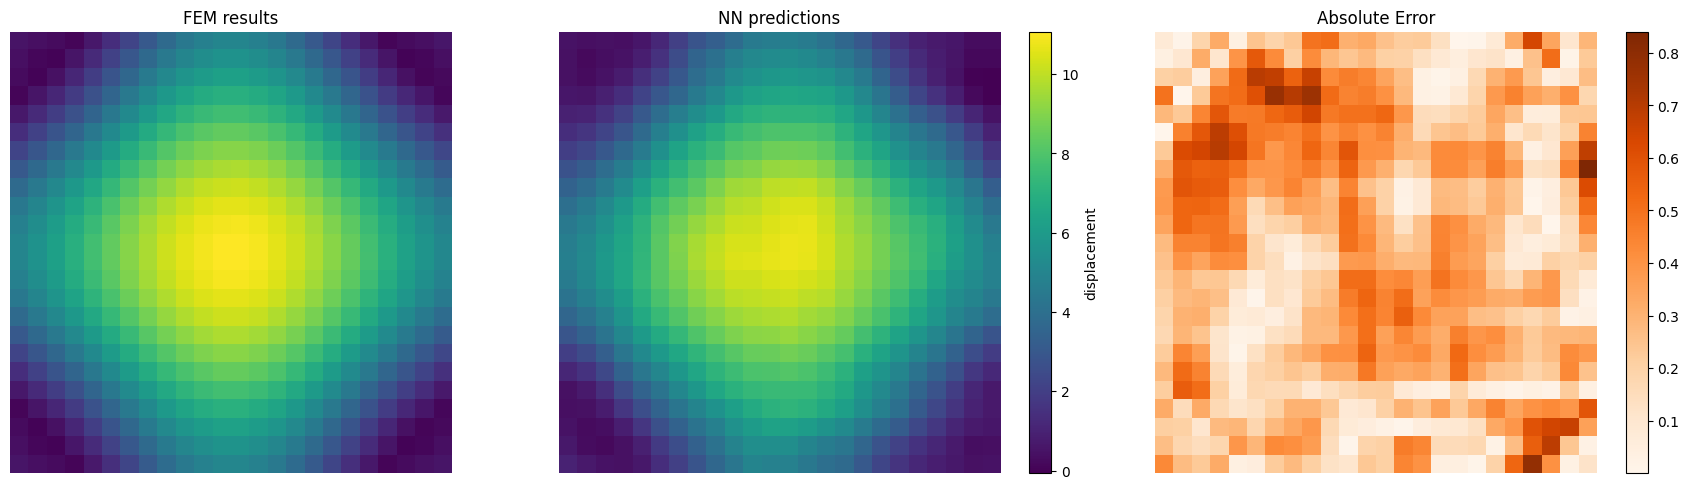

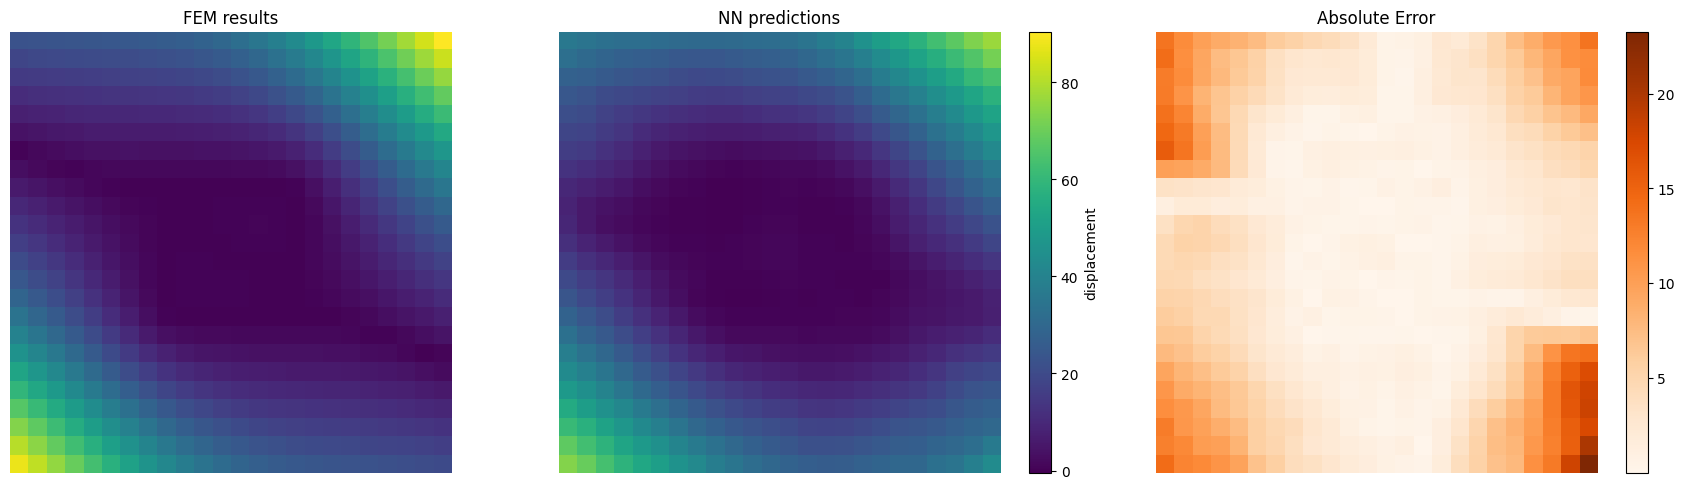

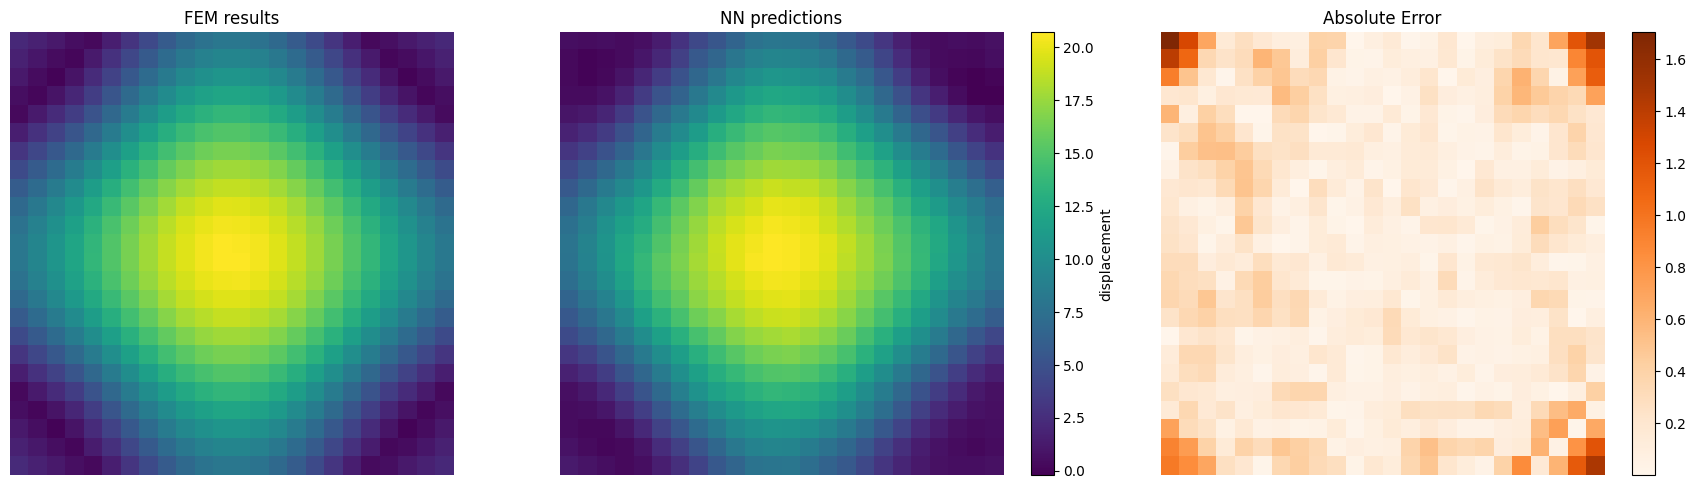

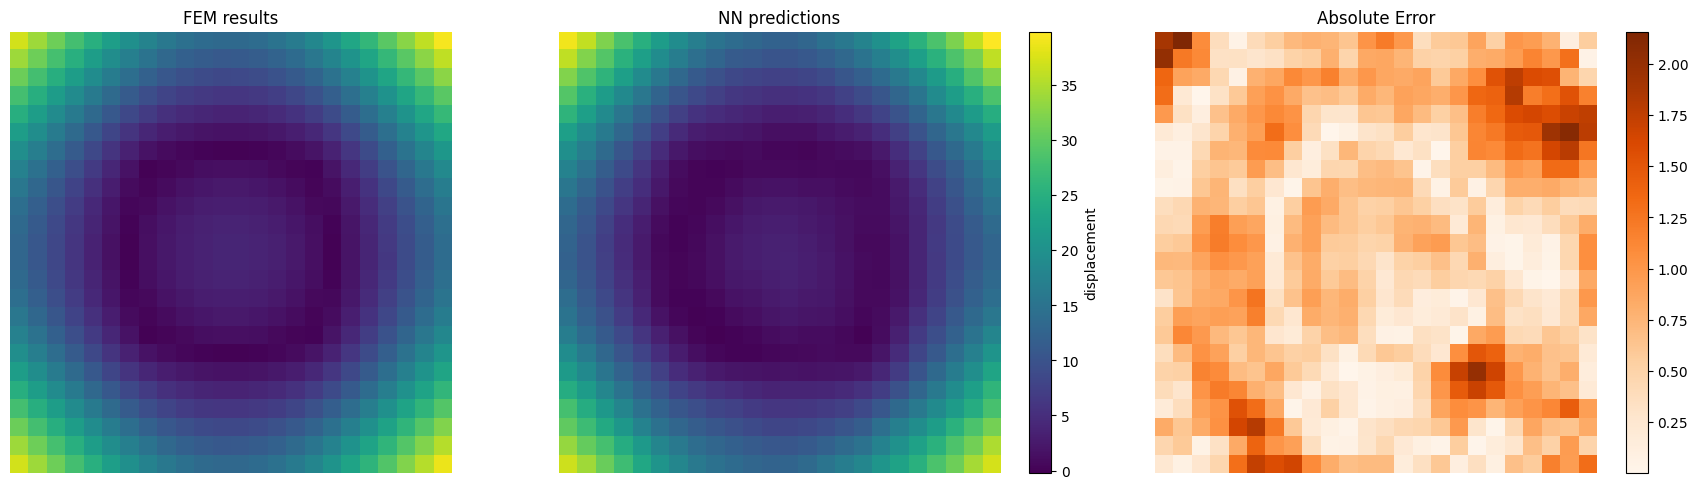

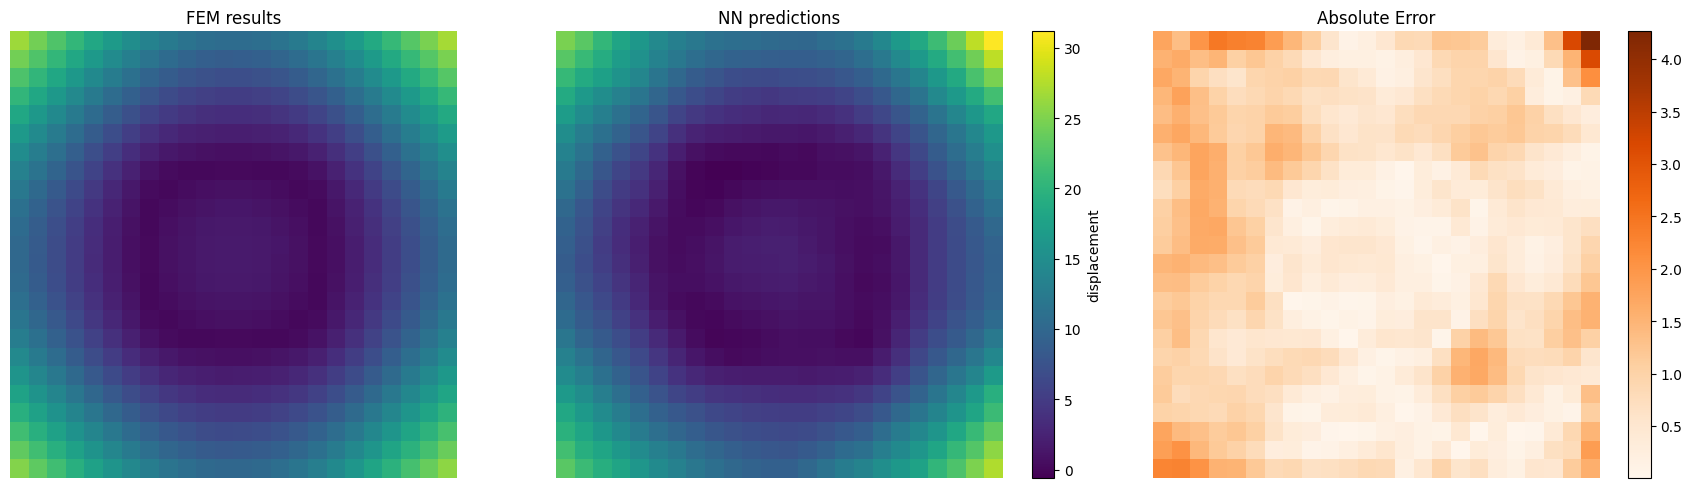

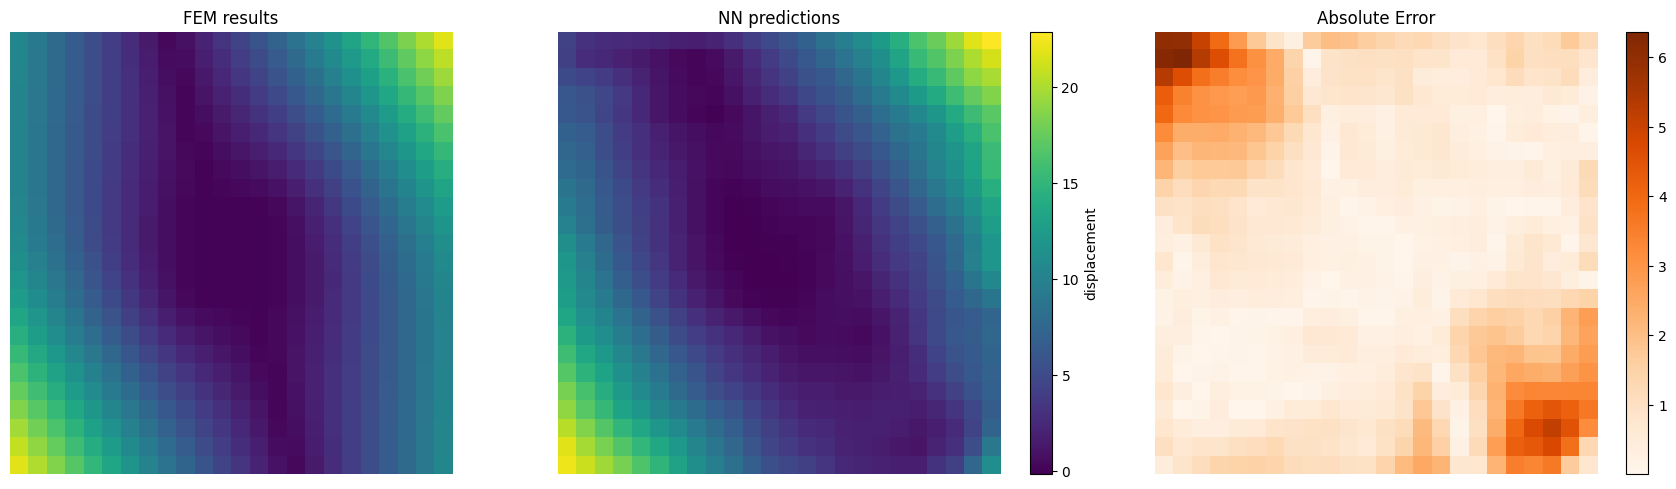

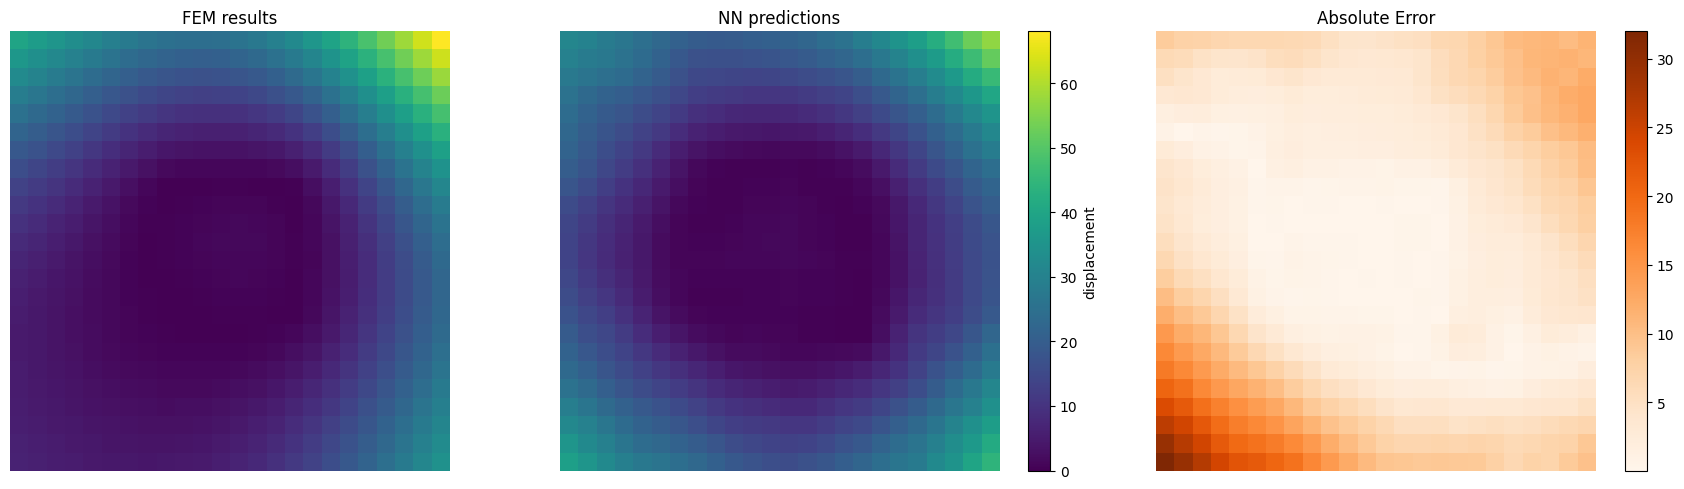

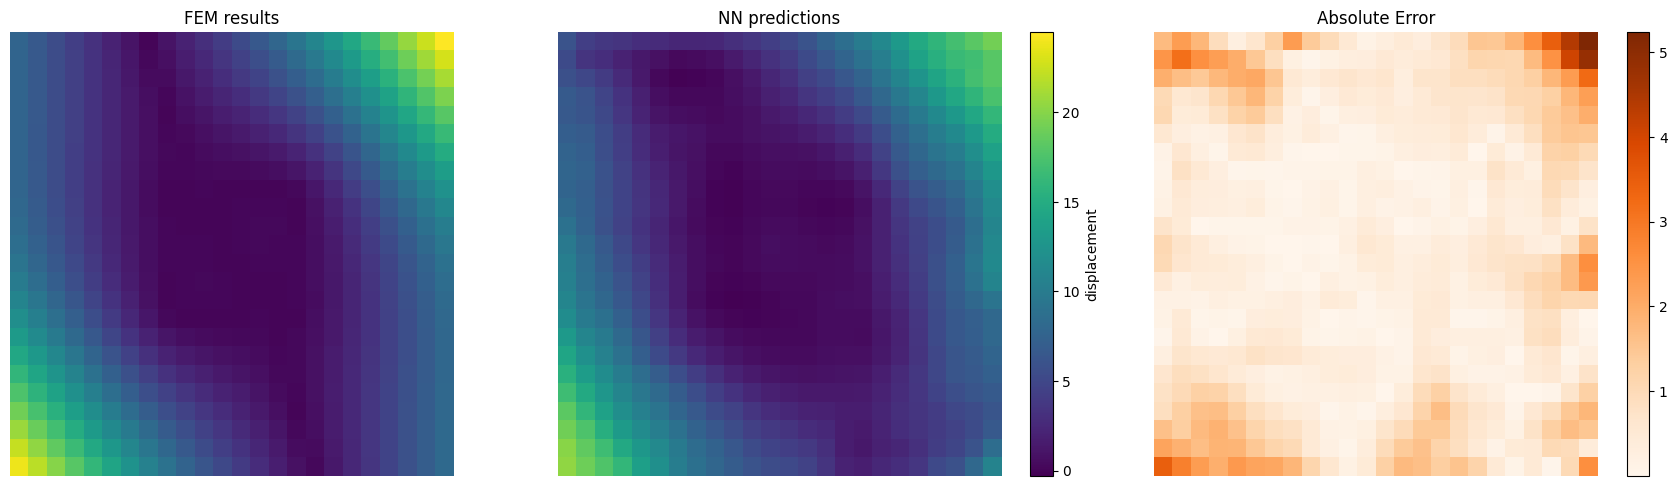

In [32]:
#visualisation inference
map_count = 20
with torch.no_grad():  
    X_test_sample = X_test[:map_count]
    X_test_sample = X_test_sample
    pred_sample = model_displacement(X_test_sample)


#pred = np.squeeze(pred.numpy(), axis=0)
pred_sample = pred_sample.cpu().numpy()
true_sample = y_test[:map_count].cpu().numpy()

print(y_pred.shape)
print(true_sample.shape)



"""
pred_denorm = denorm_y(pred_sample)
true_denorm = denorm_y(true_sample)
"""
for i in range(pred_sample.shape[0]):
    heatmaps_from_one_sample(true_sample[i].squeeze(), pred_sample[i].squeeze(), one_scale=True)


In [33]:
def incremental_train(device, X_train, y_train, X_val, y_val, X_test, y_test, incr_count = 10):
    sample_count = X_train.shape[0]
    incr = sample_count//incr_count

    train_sample_counts = []
    mse_list = []
    def reset_mse():
        return torch.tensor(1000)
    mse = reset_mse()

    for i in range(incr_count):
        if i == incr_count :
            sub_X_train = X_train
            sub_y_train = y_train
        
        else :
            train_sample_count = incr*(i+1)
            sub_X_train = X_train[:train_sample_count]
            sub_y_train = y_train[:train_sample_count]

        while mse.item() > 200 : #sometimes training is bugging
            model = INV_CNN_displacement().to(device)
            epochs, train_losses, val_losses = train(model, device, sub_X_train, sub_y_train, X_val, y_val, patience=30)

            mse = get_mse(model, X_test, y_test)

        print(f"{train_sample_count} samples, MSE: {mse.item():.4f}")

        train_sample_counts.append(train_sample_count)
        mse_list.append(mse)
        mse = reset_mse()

    return train_sample_counts, mse_list

train_sample_counts, mse_list= incremental_train(device, X_train, y_train, X_val, y_val, X_test, y_test, incr_count = 10)

cuda:0
Epoch 1/1000 - Train Loss: 491.0216 - Validation Loss: 363.7292
Epoch 2/1000 - Train Loss: 481.1448 - Validation Loss: 345.2392
Epoch 3/1000 - Train Loss: 452.4356 - Validation Loss: 304.7586
Epoch 4/1000 - Train Loss: 401.4843 - Validation Loss: 255.1588
Epoch 5/1000 - Train Loss: 338.9981 - Validation Loss: 269.6836
Epoch 6/1000 - Train Loss: 342.3110 - Validation Loss: 270.8986
Epoch 7/1000 - Train Loss: 331.5177 - Validation Loss: 246.7648
Epoch 8/1000 - Train Loss: 331.0708 - Validation Loss: 245.5063
Epoch 9/1000 - Train Loss: 332.3973 - Validation Loss: 243.9222
Epoch 10/1000 - Train Loss: 323.7521 - Validation Loss: 249.0328
Epoch 11/1000 - Train Loss: 323.7091 - Validation Loss: 264.6559
Epoch 12/1000 - Train Loss: 335.6247 - Validation Loss: 261.7608
Epoch 13/1000 - Train Loss: 328.3550 - Validation Loss: 243.6420
Epoch 14/1000 - Train Loss: 325.1548 - Validation Loss: 240.9454
Epoch 15/1000 - Train Loss: 325.0199 - Validation Loss: 240.1661
Epoch 16/1000 - Train Loss:

Text(0, 0.5, 'MSE')

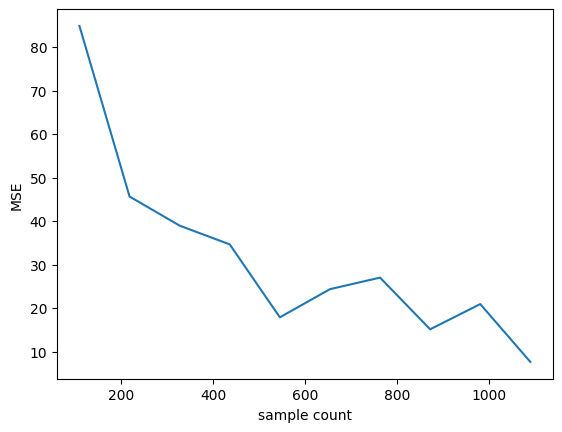

In [34]:
mse_list = [i.cpu() for i in mse_list]
plt.plot(train_sample_counts, mse_list)
plt.xlabel("sample count")
plt.ylabel("MSE")

[tensor(73.3123, device='cuda:0'), tensor(33.7981, device='cuda:0'), tensor(25.4087, device='cuda:0'), tensor(10.4723, device='cuda:0'), tensor(11.5076, device='cuda:0'), tensor(18.1958, device='cuda:0')]
